# Benchmarking binding classification with XGBoost and NN stacked


----

Stacking xgboost and NN predictions in a meta estimator.

----

- Cross validation using all data.

- Using all observations (all species, </=/> values too)

- simple one-hot encoding scheme for all categorical variables (species, hla type/subtypes,sequence)

- This is the best i can do now


----

In [1]:
import os,sys
os.environ['THEANO_FLAGS']='device=gpu1'

#my functions
sys.path.append('../')
from utils import load_all_data,my_xgb_cv_predict,my_xgb_fit_predict,my_keras_cv_predict,my_keras_fit_predict,plot_roc

#go to working dir
work_dir='/data/data1/ribli/mhc/'
os.chdir(work_dir)

%matplotlib inline

Using Theano backend.
Using gpu device 1: GeForce GTX 670 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5004)


### Load train and test data

In [5]:
X_train,y_train,y_train_c=load_all_data(
    hla_representation='one-hot',
    species_representation='one-hot',
    seq_representation='one-hot')

----


### Get xgboost CV predictions on train data, and test data


In [6]:
#model params
params = {'max_depth':20,
         'eta':0.1,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'auc',
         'nthread':8}

xgb_train_pred=my_xgb_cv_predict(params,X_train,y_train_c,n_folds=5)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.837028	eval-auc:0.811929
[500]	train-auc:0.990155	eval-auc:0.933122
[1000]	train-auc:0.996481	eval-auc:0.934676
Stopping. Best iteration:
[1224]	train-auc:0.997585	eval-auc:0.934770

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.835189	eval-auc:0.817997
[500]	train-auc:0.990345	eval-auc:0.932652
Stopping. Best iteration:
[755]	train-auc:0.994691	eval-auc:0.933318

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.837461	eval-auc:0.815366
[500]	train-auc:0.990445	eval-auc:0.933074
[1000]	train-auc:0.996677	eval-auc:0.934935
Stopping. Best iteration:
[978]	train-auc:0.996531	eval-auc:0.935068

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.855848	eval-auc:0.842424
[500]	train-auc:0.990589	eval-auc:0.937817
[1000]	train-auc:0.996746	eval-auc:0.938814
Stopping. Best iteration:
[1086]	train-auc:0.997222	eval-auc:0.938882

Will train

### Do the same with NN

In [7]:
#create a very simple model
from keras.models import Sequential
from keras.layers import Dense

#create model creator
def get_model(input_dim):
    """Creates Keras model needed."""
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

#predict CV
nn_train_pred=my_keras_cv_predict(get_model,X_train,y_train_c,n_folds=5,patience=3,verbose=2)

Train on 119040 samples, validate on 13227 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.40322, saving model to best_model
3s - loss: 0.4179 - val_loss: 0.4032
Epoch 2/100
Epoch 00001: val_loss improved from 0.40322 to 0.36684, saving model to best_model
3s - loss: 0.3122 - val_loss: 0.3668
Epoch 3/100
Epoch 00002: val_loss improved from 0.36684 to 0.34443, saving model to best_model
3s - loss: 0.2758 - val_loss: 0.3444
Epoch 4/100
Epoch 00003: val_loss improved from 0.34443 to 0.33257, saving model to best_model
3s - loss: 0.2515 - val_loss: 0.3326
Epoch 5/100
Epoch 00004: val_loss improved from 0.33257 to 0.32562, saving model to best_model
3s - loss: 0.2296 - val_loss: 0.3256
Epoch 6/100
Epoch 00005: val_loss did not improve
3s - loss: 0.2109 - val_loss: 0.3459
Epoch 7/100
Epoch 00006: val_loss did not improve
3s - loss: 0.1932 - val_loss: 0.3437
Epoch 8/100
Epoch 00007: val_loss did not improve
3s - loss: 0.1763 - val_loss: 0.3557
Epoch 9/100
Epoch 00008: val_los

### Create stacked inputs

In [8]:
import numpy as np
X_train_stacked=np.column_stack([X_train,xgb_train_pred,nn_train_pred])

#save them for the future
np.save('class_stacked_x_train',X_train_stacked)

### Make prediction with xgb on the stacked inputs

In [9]:
params = {'max_depth':3,
         'eta':0.1,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'auc',
         'nthread':8}

xgb_stacked_train_pred=my_xgb_cv_predict(params,X_train_stacked,y_train_c,n_folds=5)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.928707	eval-auc:0.924539
Stopping. Best iteration:
[146]	train-auc:0.942384	eval-auc:0.938189

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.928192	eval-auc:0.930280
Stopping. Best iteration:
[59]	train-auc:0.940537	eval-auc:0.941310

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.929270	eval-auc:0.926162
Stopping. Best iteration:
[264]	train-auc:0.943223	eval-auc:0.939412

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.929884	eval-auc:0.927427
Stopping. Best iteration:
[87]	train-auc:0.942014	eval-auc:0.939714

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.928310	eval-auc:0.931126
Stopping. Best iteration:
[72]	train-auc:0.941047	eval-auc:0.941833



### Evaluate

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
def bootstrap_auc(y_c,y_pred,N=100):
    """Bootstrap the AUC score."""
    scores=[]
    for i in xrange(N):
        res_y=resample(np.column_stack([y_c,y_pred]))
        scores.append(roc_auc_score(res_y[:,0],res_y[:,1]))
        
    print 'Score is :', '%.4f' % np.mean(scores),
    print '+-','%.4f' % np.std(scores)

In [11]:
bootstrap_auc(y_train_c,xgb_stacked_train_pred)

Score is : 0.9392 +- 0.0006


AUC: 0.939167728263


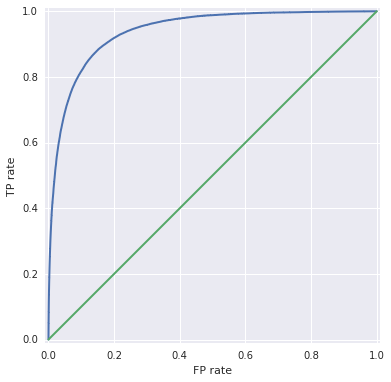

In [12]:
plot_roc(y_train_c,xgb_stacked_train_pred)